
# Import packages

In [1]:
import sys
import pandas as pd
import numpy as np
import glob
import os
import scipy.stats as st
import random
import matplotlib.pyplot as plt

sys.path.append('../../')
from utils import dataframe_utils

In [2]:
satellite_ttherm_ids = list((pd.read_csv('./selected-annotation-data.tsv', delimiter='\t'))['TTHERM_ID'].values)

In [3]:
len(satellite_ttherm_ids)

604

# Import the data for each timepoint

In [4]:
# file_paths = sorted(glob.glob('./rna_seq_count_data/kallisto_quant_2024/kallisto_quant_p_trimmed_*'))
# file_paths = sorted(glob.glob('./rna_seq_count_data/kallisto_quant_2024_exon/kallisto_quant_p_trimmed_*'))
file_paths = sorted(glob.glob('./rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_*'))
file_paths

['./rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_000min_A',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_000min_B',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_030min_A',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_030min_B',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_060min_A',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_060min_B',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_090min_A',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_090min_B',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_120min_A',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_120min_B',
 './rna_seq_count_data/kallisto_quant_2024_may15_cds/kallisto_quant_p_trimmed_150min_A',
 './rna_seq_count_dat

In [5]:
dict_tpms = {}

for fp in file_paths:
    split = ((os.path.splitext(os.path.basename(fp))[0]).split('_'))
    key = '_'.join(split[len(split)-2:len(split)])
    print(key)
    dict_tpms[key] = (pd.read_csv(os.path.join(fp, 'abundance.tsv'), delimiter='\t'))

print(np.unique([df.shape for df in dict_tpms.values()]))

000min_A
000min_B
030min_A
030min_B
060min_A
060min_B
090min_A
090min_B
120min_A
120min_B
150min_A
150min_B
180min_A
180min_B
210min_A
210min_B
240min_A
240min_B
[    5 26686]


In [6]:
dict_tpms['000min_A'].head()

,target_id,length,eff_length,est_counts,tpm
0,TTHERM_00161861,420,233.970,12.0,0.497783
1,TTHERM_00161860,4356,4167.310,11088.0,25.823600
2,TTHERM_00161850,1200,1011.310,102.0,0.978896
3,TTHERM_00161840,498,310.160,907.0,28.381800
4,TTHERM_00161830,1077,888.305,1320.0,14.422200


In [7]:
def computeRPK(row):
    if not row['eff_length'] > 0:
        print('ZERO sequence length:', row['target_id'])
        print(row)
        return 'ZERO sequence length'
    return row['est_counts']/row['eff_length']

def computeTPM(row, normalization_factor):
    return row['rpk']/normalization_factor

def compute_tpm_columns(df_dict):
    df_tpm = {}
    normalization_factor_dict = {}
    for key, df in df_dict.items():
        tpm_df = df
        tpm_df['rpk'] = tpm_df.apply(computeRPK, axis=1)
        tpm_df = tpm_df.loc[tpm_df['rpk']!='ZERO sequence length']

        sum_rpk = tpm_df['rpk'].sum()

        normalization_factor = sum_rpk/1_000_000

        tpm_df['tpm_manual'] = tpm_df.apply(computeTPM, axis=1, args=(normalization_factor,))

        df_tpm[key] = tpm_df  
        normalization_factor_dict[key] = normalization_factor

    return df_tpm, normalization_factor_dict

def compute_cpm_columns(df_dict):
    df_cpm = {}
    for key, df in df_dict.items():
        cpm_df = df

        sum_count = cpm_df['est_counts'].sum()

        cpm_df['cpm_manual'] = (cpm_df['est_counts'] / sum_count) * 1_000_000

        df_cpm[key] = cpm_df  

    return df_cpm

In [8]:
dict_tpms, norm_factors_dict = compute_tpm_columns(dict_tpms)

In [9]:
dict_tpms['150min_A'].head()

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual
0,TTHERM_00161861,420,237.019,10.0,0.468639,0.042191,0.468640
1,TTHERM_00161860,4356,4170.190,14919.0,39.738000,3.577535,39.738035
2,TTHERM_00161850,1200,1014.190,1122.0,12.288400,1.106302,12.288420
3,TTHERM_00161840,498,313.352,1276.0,45.231400,4.072098,45.231472
4,TTHERM_00161830,1077,891.188,1585.0,19.755200,1.778525,19.755247


In [10]:
dict_cpms = compute_cpm_columns(dict_tpms)

In [11]:
dict_cpms['150min_A'].head()

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual,cpm_manual
0,TTHERM_00161861,420,237.019,10.0,0.468639,0.042191,0.468640,0.203044
1,TTHERM_00161860,4356,4170.190,14919.0,39.738000,3.577535,39.738035,302.921274
2,TTHERM_00161850,1200,1014.190,1122.0,12.288400,1.106302,12.288420,22.781532
3,TTHERM_00161840,498,313.352,1276.0,45.231400,4.072098,45.231472,25.908408
4,TTHERM_00161830,1077,891.188,1585.0,19.755200,1.778525,19.755247,32.182467


In [12]:
norm_factors_dict

{'000min_A': 0.10303414297633703,
 '000min_B': 0.11791540352418764,
 '030min_A': 0.10915982283130497,
 '030min_B': 0.10463058515758553,
 '060min_A': 0.102845475286628,
 '060min_B': 0.12889080980690892,
 '090min_A': 0.09454311921976888,
 '090min_B': 0.10974495111513312,
 '120min_A': 0.09550681802512544,
 '120min_B': 0.11879205488565693,
 '150min_A': 0.0900279746989677,
 '150min_B': 0.11208319140983425,
 '180min_A': 0.10839478318267406,
 '180min_B': 0.10840992221608604,
 '210min_A': 0.08197215799905486,
 '210min_B': 0.10333356964583025,
 '240min_A': 0.11867116125667991,
 '240min_B': 0.11095891185161426}

In [13]:
ttherm_id = 'YF00013476.t1'

dict_tpms['000min_A'].loc[dict_tpms['000min_A']['target_id'] == ttherm_id]

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual,cpm_manual


In [14]:
dict_tpms['000min_A'].shape

(26686, 8)

## Checkout a single timepoint

In [15]:
num_nonzero = (dict_tpms['000min_A'].loc[dict_tpms['000min_A']['tpm'] != 0.0].shape)[0]

mean = dict_tpms['000min_A']['tpm'].mean()

std = dict_tpms['000min_A']['tpm'].std()

str_summary_wzeros = f'''WITH ZEROS...
MEAN: {mean}
MEDIAN: {dict_tpms['000min_A']['tpm'].median()}
STDEV: {std}
CV: {(std/mean)*100}
MAX: {dict_tpms['000min_A']['tpm'].max()}
MIN: {dict_tpms['000min_A']['tpm'].min()}
# GENES EXPRESSED: {num_nonzero}
'''

df_tpm_wozeros = dict_tpms['000min_A'].loc[dict_tpms['000min_A']['tpm'] != 0.0]

mean_wozeros = df_tpm_wozeros['tpm'].mean()

std_wozeros = df_tpm_wozeros['tpm'].std()

str_summary_wozeros = f'''WITHOUT ZEROS...
MEAN: {mean_wozeros}
MEDIAN: {df_tpm_wozeros['tpm'].median()}
STDEV: {std_wozeros}
CV: {(std_wozeros/mean_wozeros)*100}
MAX: {df_tpm_wozeros['tpm'].max()}
MIN: {df_tpm_wozeros['tpm'].min()}
# GENES EXPRESSED: {num_nonzero}
'''

print(str_summary_wzeros, '\n', str_summary_wozeros, sep='')


WITH ZEROS...
MEAN: 37.47283133302976
MEDIAN: 0.820622
STDEV: 386.9901408522003
CV: 1032.7219136790839
MAX: 29123.3
MIN: 0.0
# GENES EXPRESSED: 23538

WITHOUT ZEROS...
MEAN: 42.484492180866354
MEDIAN: 1.24506
STDEV: 411.7991695803123
CV: 969.2929076972076
MAX: 29123.3
MIN: 1.60642e-08
# GENES EXPRESSED: 23538



# Create a dataframe containing all data at every timepoint (sorted by TTHERM_ID)

In [16]:
column_prefixes = sorted(list(dict_tpms.keys()))
column_prefixes

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [17]:
complete_data_df = None

for col_prefix in column_prefixes:
    curr_df = dict_tpms[col_prefix].sort_values(by='target_id')
    curr_df.rename(columns={col: (f'{col_prefix}_{col}') for col in list(curr_df.columns) if col != 'target_id'}, inplace=True)

    if complete_data_df is None:
        complete_data_df = curr_df
        continue

    complete_data_df = dataframe_utils.sql_query_df({'complete_data_df': complete_data_df, 'curr_df': curr_df},
                                                    '''SELECT * FROM complete_data_df
                                                       INNER JOIN curr_df USING(target_id)'''
                                                    )

complete_data_df.rename(columns={'target_id': 'TTHERM_ID'}, inplace=True)
complete_data_df


,TTHERM_ID,000min_A_length,000min_A_eff_length,000min_A_est_counts,000min_A_tpm,000min_A_rpk,000min_A_tpm_manual,000min_A_cpm_manual,000min_B_length,000min_B_eff_length,...,240min_A_rpk,240min_A_tpm_manual,240min_A_cpm_manual,240min_B_length,240min_B_eff_length,240min_B_est_counts,240min_B_tpm,240min_B_rpk,240min_B_tpm_manual,240min_B_cpm_manual
0,TTHERM_00000010,1587,1398.310,347.0000,2.408500,0.248157,2.408490,6.188055,1587,1400.260,...,0.057392,0.483623,1.301825,1587,1396.910,86.0000,0.554840,0.061564,0.554840,1.505942
1,TTHERM_00000020,1665,1476.310,10.0000,0.065742,0.006774,0.065742,0.178330,1665,1478.260,...,0.029893,0.251897,0.716004,1665,1474.910,13.0000,0.079436,0.008814,0.079436,0.227642
2,TTHERM_00000030,1887,1698.310,54.0000,0.308601,0.031796,0.308600,0.962983,1887,1700.260,...,0.002952,0.024873,0.081364,1887,1696.910,2.0000,0.010622,0.001179,0.010622,0.035022
3,TTHERM_00000031,360,176.930,0.0000,0.000000,0.000000,0.000000,0.000000,360,178.711,...,0.000000,0.000000,0.000000,360,175.714,0.0000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,2958,2769.310,644.0000,2.257010,0.232549,2.257008,11.484459,2958,2771.260,...,0.211941,1.785952,9.535872,2958,2767.910,668.0000,2.175010,0.241337,2.175015,11.697315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26681,TTHERM_02653514,924,735.305,0.0000,0.000000,0.000000,0.000000,0.000000,924,737.264,...,0.000000,0.000000,0.000000,924,733.911,0.0000,0.000000,0.000000,0.000000,0.000000
26682,TTHERM_02653516,897,708.305,77.0157,1.055300,0.108732,1.055305,1.373422,897,710.264,...,0.068219,0.574854,0.781426,897,706.911,51.0228,0.650485,0.072177,0.650485,0.893458
26683,TTHERM_02653518,1443,1254.310,186.3350,1.441810,0.148556,1.441811,3.322914,1443,1256.260,...,0.144849,1.220594,2.946194,1443,1252.910,163.0530,1.172860,0.130139,1.172861,2.855213
26684,TTHERM_06324284,1797,1608.310,285.1850,1.720980,0.177320,1.720980,5.085707,1797,1610.260,...,0.155302,1.308675,4.053429,1797,1606.910,247.1160,1.385950,0.153783,1.385949,4.327236


# SATELLITE GENE COUNTS

In [18]:
(complete_data_df[['TTHERM_ID'] + [col for col in complete_data_df if 'counts' in col]].loc[complete_data_df['TTHERM_ID'].isin(satellite_ttherm_ids)])

,TTHERM_ID,000min_A_est_counts,000min_B_est_counts,030min_A_est_counts,030min_B_est_counts,060min_A_est_counts,060min_B_est_counts,090min_A_est_counts,090min_B_est_counts,120min_A_est_counts,120min_B_est_counts,150min_A_est_counts,150min_B_est_counts,180min_A_est_counts,180min_B_est_counts,210min_A_est_counts,210min_B_est_counts,240min_A_est_counts,240min_B_est_counts


In [19]:
# 10 reads cuttoff
complete_data_df['max_count'] = complete_data_df[[col for col in complete_data_df if 'counts' in col]].apply(lambda x: max(x), axis=1)

In [20]:
complete_data_df_filtered = complete_data_df.loc[complete_data_df['max_count'] > 10]
complete_data_df_filtered

,TTHERM_ID,000min_A_length,000min_A_eff_length,000min_A_est_counts,000min_A_tpm,000min_A_rpk,000min_A_tpm_manual,000min_A_cpm_manual,000min_B_length,000min_B_eff_length,...,240min_A_tpm_manual,240min_A_cpm_manual,240min_B_length,240min_B_eff_length,240min_B_est_counts,240min_B_tpm,240min_B_rpk,240min_B_tpm_manual,240min_B_cpm_manual,max_count
0,TTHERM_00000010,1587,1398.3100,347.0000,2.408500,0.248157,2.408490,6.188055,1587,1400.2600,...,0.483623,1.301825,1587,1396.9100,86.0000,0.554840,0.061564,0.554840,1.505942,450.0000
1,TTHERM_00000020,1665,1476.3100,10.0000,0.065742,0.006774,0.065742,0.178330,1665,1478.2600,...,0.251897,0.716004,1665,1474.9100,13.0000,0.079436,0.008814,0.079436,0.227642,44.0000
2,TTHERM_00000030,1887,1698.3100,54.0000,0.308601,0.031796,0.308600,0.962983,1887,1700.2600,...,0.024873,0.081364,1887,1696.9100,2.0000,0.010622,0.001179,0.010622,0.035022,54.0000
4,TTHERM_00000040,2958,2769.3100,644.0000,2.257010,0.232549,2.257008,11.484459,2958,2771.2600,...,1.785952,9.535872,2958,2767.9100,668.0000,2.175010,0.241337,2.175015,11.697315,833.0000
5,TTHERM_00000047,2505,2316.3100,30.0000,0.125703,0.012952,0.125702,0.534990,2505,2318.2600,...,0.211402,0.943823,2505,2314.9100,161.0000,0.626801,0.069549,0.626801,2.819263,480.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26679,TTHERM_02653503,270,98.3061,10.0000,0.987275,0.101723,0.987276,0.178330,270,99.5922,...,2.295394,0.423093,270,97.3952,34.0000,3.146150,0.349093,3.146148,0.595372,73.0000
26680,TTHERM_02653508,1341,1152.3100,1037.2400,8.736360,0.900140,8.736325,18.497112,1341,1154.2600,...,9.222757,20.444681,1341,1150.9100,1285.1600,10.063600,1.116647,10.063607,22.504372,2518.7800
26682,TTHERM_02653516,897,708.3050,77.0157,1.055300,0.108732,1.055305,1.373422,897,710.2640,...,0.574854,0.781426,897,706.9110,51.0228,0.650485,0.072177,0.650485,0.893458,83.0674
26683,TTHERM_02653518,1443,1254.3100,186.3350,1.441810,0.148556,1.441811,3.322914,1443,1256.2600,...,1.220594,2.946194,1443,1252.9100,163.0530,1.172860,0.130139,1.172861,2.855213,186.3350


# SATELLITE GENE COUNTS AFTER FILTERING

In [21]:
(complete_data_df_filtered[['TTHERM_ID'] + [col for col in complete_data_df_filtered if 'counts' in col]].loc[complete_data_df_filtered['TTHERM_ID'].isin(satellite_ttherm_ids)])

,TTHERM_ID,000min_A_est_counts,000min_B_est_counts,030min_A_est_counts,030min_B_est_counts,060min_A_est_counts,060min_B_est_counts,090min_A_est_counts,090min_B_est_counts,120min_A_est_counts,120min_B_est_counts,150min_A_est_counts,150min_B_est_counts,180min_A_est_counts,180min_B_est_counts,210min_A_est_counts,210min_B_est_counts,240min_A_est_counts,240min_B_est_counts


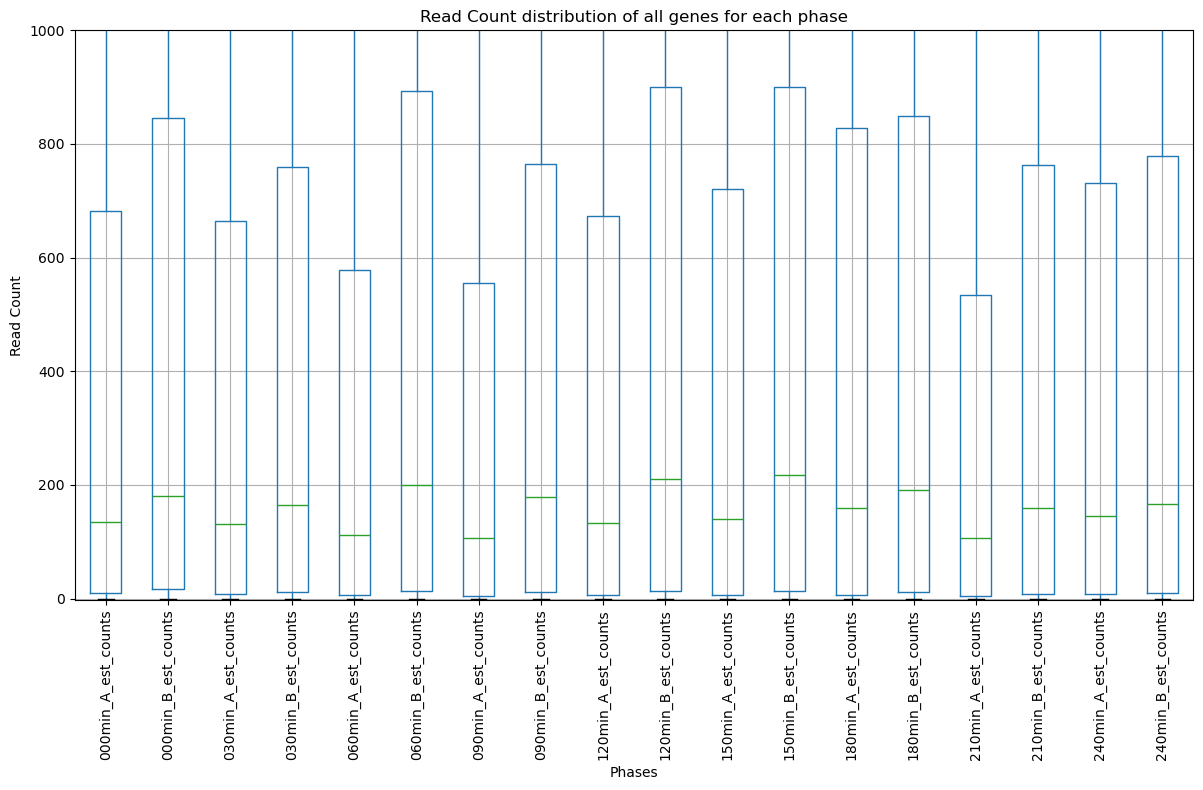

In [22]:
# Assuming you have your gene expression dataset loaded into a DataFrame called 'data'
# Columns: Genes (rows), Phases (columns)
# Rows: Genes, Expression values across phases

df_data = complete_data_df.loc[:, [col for col in complete_data_df if 'counts' in col]]

# Plot boxplot for each phase
plt.figure(figsize=(12, 8))
df_data.boxplot(rot=90)
plt.title('Read Count distribution of all genes for each phase')
plt.xlabel('Phases')
plt.ylabel('Read Count')
plt.tight_layout()
plt.ylim(top=1000)
plt.ylim(bottom=-2.5)
plt.show()

# Create a dataframe containing all TPM data at every timepoint (sorted by TTHERM_ID)

In [23]:
columns = sorted(list(dict_tpms.keys()))
columns

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [24]:
curr_df = dict_tpms['000min_A'].sort_values(by='target_id')
dict_df_all_tpm = {'TTHERM_ID': curr_df['target_id'].values}
print(curr_df.head(3))

for col in columns:
    curr_df = dict_tpms[col].sort_values(by='target_id')
    print(curr_df.head(3))
    dict_df_all_tpm[col] = (curr_df)['tpm'].values

df_all_tpm = pd.DataFrame(dict_df_all_tpm)

print(df_all_tpm.shape)

df_all_tpm.head()

            target_id  length  eff_length  est_counts       tpm       rpk  \
9249  TTHERM_00000010    1587     1398.31       347.0  2.408500  0.248157   
9248  TTHERM_00000020    1665     1476.31        10.0  0.065742  0.006774   
9247  TTHERM_00000030    1887     1698.31        54.0  0.308601  0.031796   

      tpm_manual  cpm_manual  
9249    2.408490    6.188055  
9248    0.065742    0.178330  
9247    0.308600    0.962983  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9249  TTHERM_00000010    1587     1398.31       347.0  2.408500  0.248157   
9248  TTHERM_00000020    1665     1476.31        10.0  0.065742  0.006774   
9247  TTHERM_00000030    1887     1698.31        54.0  0.308601  0.031796   

      tpm_manual  cpm_manual  
9249    2.408490    6.188055  
9248    0.065742    0.178330  
9247    0.308600    0.962983  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9249  TTHERM_00000010    1587     1400.26       118.0  0.

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,0.330559,0.317093,0.350251,0.456802,0.436540,0.368480,0.501366,0.483624,0.554840
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,0.045545,0.112639,0.030162,0.031347,0.068903,0.091381,0.052747,0.251897,0.079436
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,0.014850,0.019588,0.010490,0.010895,0.027217,0.028866,0.005727,0.024873,0.010622
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,2.232350,2.203750,2.413930,1.952220,2.414790,1.837740,1.938460,1.785950,2.175010


In [25]:
all_cols = list(df_all_tpm.columns)
all_cols

['TTHERM_ID',
 '000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [26]:
tpm_cols = [col for col in df_all_tpm.columns[1:] if 'diff' not in col]
tpm_cols

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

# Create a dataframe containing all CPM data at every timepoint (sorted by TTHERM_ID)

In [27]:
columns = sorted(list(dict_tpms.keys()))
columns

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [28]:
curr_df = dict_cpms['000min_A'].sort_values(by='target_id')
dict_df_all_cpm = {'TTHERM_ID': curr_df['target_id'].values}
print(curr_df.head(3))

for col in columns:
    curr_df = dict_cpms[col].sort_values(by='target_id')
    print(curr_df.head(3))
    dict_df_all_cpm[col] = (curr_df)['cpm_manual'].values

df_all_cpm = pd.DataFrame(dict_df_all_cpm)

print(df_all_cpm.shape)

df_all_cpm.head()

            target_id  length  eff_length  est_counts       tpm       rpk  \
9249  TTHERM_00000010    1587     1398.31       347.0  2.408500  0.248157   
9248  TTHERM_00000020    1665     1476.31        10.0  0.065742  0.006774   
9247  TTHERM_00000030    1887     1698.31        54.0  0.308601  0.031796   

      tpm_manual  cpm_manual  
9249    2.408490    6.188055  
9248    0.065742    0.178330  
9247    0.308600    0.962983  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9249  TTHERM_00000010    1587     1398.31       347.0  2.408500  0.248157   
9248  TTHERM_00000020    1665     1476.31        10.0  0.065742  0.006774   
9247  TTHERM_00000030    1887     1698.31        54.0  0.308601  0.031796   

      tpm_manual  cpm_manual  
9249    2.408490    6.188055  
9248    0.065742    0.178330  
9247    0.308600    0.962983  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9249  TTHERM_00000010    1587     1400.26       118.0  0.

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,6.188055,2.218046,7.873441,4.494121,1.514111,1.664427,0.521891,1.239052,0.625592,1.008829,0.812176,1.105647,1.167824,1.234043,0.943127,1.327621,1.301825,1.505942
1,TTHERM_00000020,0.178330,0.056391,0.297441,0.082461,0.189264,0.225391,0.271383,0.020312,0.363247,0.146739,0.304566,0.100513,0.084625,0.205674,0.247010,0.147513,0.716004,0.227642
2,TTHERM_00000030,0.962983,0.112782,0.069986,0.000000,0.000000,0.034676,0.083503,0.101562,0.040361,0.055027,0.060913,0.040205,0.033850,0.093488,0.089822,0.018439,0.081364,0.035022
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018342,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,11.484459,15.657899,7.715972,9.627313,9.236078,11.633653,9.957680,12.492081,10.877235,13.481628,11.167417,15.076998,9.901115,13.537077,9.341452,10.196866,9.535872,11.697315


# Jaccard filtering: https://academic.oup.com/bioinformatics/article/29/17/2146/240530#SEC2.2

In [29]:
cols_a = [col for col in df_all_cpm if 'A' in col]
cols_a

['000min_A',
 '030min_A',
 '060min_A',
 '090min_A',
 '120min_A',
 '150min_A',
 '180min_A',
 '210min_A',
 '240min_A']

In [30]:
def jaccard_similarity(set1, set2):
    # intersection of two sets
    intersection = len(set1.intersection(set2))
    # Unions of two sets
    union = len(set1.union(set2))
     
    return intersection / union

In [31]:
np.percentile(df_all_cpm.loc[:, tpm_cols].to_numpy().flatten(), 14)

0.01843917889932433

In [32]:
percentiles = np.arange(14, 31, 0.1)

tpm_cutoffs = []

jaccard_similarity_means = []

for _percentile in percentiles:

    tpm_cutoff = np.percentile(df_all_cpm.loc[:, tpm_cols].to_numpy().flatten(), _percentile)

    tpm_cutoffs.append(tpm_cutoff)

    jaccard_similarities = []

    for col_a in cols_a:
        col_b = col_a.replace('A', 'B')

        jaccard_similarities.append(jaccard_similarity(set(df_all_cpm.loc[df_all_cpm[col_a] > tpm_cutoff, 'TTHERM_ID'].values), 
                                                        set(df_all_cpm.loc[df_all_cpm[col_b] > tpm_cutoff, 'TTHERM_ID'].values)))

    jaccard_similarity_means.append(np.mean(jaccard_similarities))


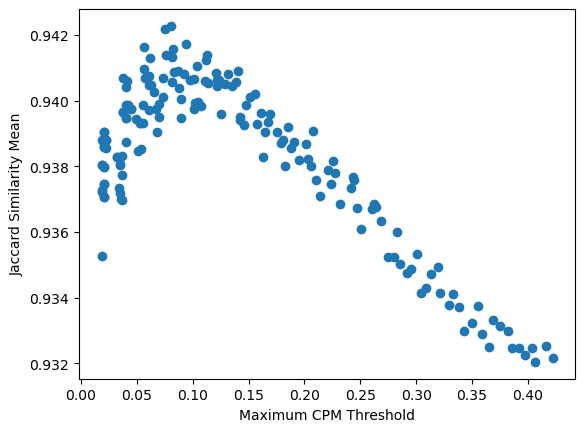

In [33]:
plt.scatter(x=tpm_cutoffs, y=jaccard_similarity_means)
plt.xlabel('Maximum CPM Threshold')
plt.ylabel('Jaccard Similarity Mean')
plt.show()

In [34]:
print(np.argmax(jaccard_similarity_means))
print(jaccard_similarity_means[np.argmax(jaccard_similarity_means)])
print(tpm_cutoffs[np.argmax(jaccard_similarity_means)])

68
0.9422724634302378
0.08041065599396688


In [35]:
CPM_THRESHOLD = tpm_cutoffs[np.argmax(jaccard_similarity_means)]

In [36]:
df_all_cpm['max_cpm'] = df_all_cpm[tpm_cols].apply(lambda x: max(x), axis=1)

In [37]:
df_all_cpm_filtered = df_all_cpm.loc[df_all_cpm['max_cpm'] > CPM_THRESHOLD]
df_all_cpm_filtered.shape, df_all_cpm.shape

((23112, 20), (26686, 20))

In [38]:
((df_all_cpm_filtered[['TTHERM_ID'] + tpm_cols].loc[df_all_cpm_filtered['TTHERM_ID'].isin(satellite_ttherm_ids)])).shape

(0, 19)

# Translate to TTHERM_ID

In [39]:
df_y_to_ttherm = pd.read_csv('../tgd2024/yf_ttherm_mapping_feb2024.csv')
dict_y_to_ttherm = {yf: ttherm for yf, ttherm in zip(df_y_to_ttherm['yf2024'].values, df_y_to_ttherm['ttherm2021'].values)}

In [40]:
dict_y_to_ttherm

{'YF00003507.t1': 'TTHERM_00655860',
 'YF00028628.t1': 'TTHERM_00927120',
 'YF00019461.t1': 'TTHERM_00716070',
 'YF00018024.t1': 'TTHERM_00188330',
 'YF00011744.t1': 'TTHERM_00264990',
 'YF00000692.t1': 'TTHERM_00301690',
 'YF00020018.t1': 'TTHERM_00571650',
 'YF00027771.t1': 'TTHERM_001414123',
 'YF00005353.t1': 'TTHERM_00146080',
 'YF00007877.t1': 'TTHERM_000672289',
 'YF00013833.t1': 'TTHERM_00335730',
 'YF00009042.t1': 'TTHERM_00427470',
 'YF00015223.t1': 'TTHERM_00170160',
 'YF00000272.t1': 'TTHERM_00155480',
 'YF00015664.t1': 'TTHERM_00660400',
 'YF00005973.t1': 'TTHERM_00522430',
 'YF00028690.t1': 'TTHERM_00945200',
 'YF00001875.t1': 'TTHERM_000492719',
 'YF00004732.t1': 'TTHERM_00467760',
 'YF00018327.t1': 'TTHERM_00823880',
 'YF00001113.t1': 'TTHERM_00217210',
 'YF00016026.t1': 'TTHERM_00225760',
 'YF00013217.t1': 'TTHERM_00134890',
 'YF00009571.t1': 'TTHERM_00709740',
 'YF00004778.t1': 'TTHERM_00467320',
 'YF00001824.t1': 'TTHERM_00492320',
 'YF00025848.t1': 'TTHERM_00979890'

In [41]:
# df_all_tpm['TTHERM_ID'] = [dict_y_to_ttherm[id] if id in dict_y_to_ttherm else id for id in df_all_tpm['TTHERM_ID'].values]
df_all_tpm.sample(10)

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
11673,TTHERM_00449010,10.125200,6.168810,6.924470,6.294210,5.419560,5.856260,5.093770,5.347010,4.195120,4.281920,4.685950,4.184780,5.277350,4.568940,7.292140,5.360510,7.891480,6.617650
6155,TTHERM_00242044,0.051649,0.259164,0.488926,0.279796,0.621658,0.450228,0.541785,0.716630,0.549604,0.575875,0.589975,0.746449,0.732616,0.719682,0.628116,0.479096,0.511586,0.510050
9483,TTHERM_00362950,0.077511,0.134786,0.000000,0.050930,0.000000,0.125178,0.000000,0.073315,0.000000,0.044534,0.000000,0.094377,0.000000,0.049579,0.000000,0.000000,0.022682,0.072270
17462,TTHERM_00674500,0.020447,0.028563,0.023203,0.038674,0.020500,0.075318,0.044568,0.030753,0.030860,0.042522,0.037397,0.060080,0.027266,0.046713,0.030943,0.032739,0.017786,0.022798
21554,TTHERM_00913360,0.157764,0.464334,0.065439,0.310818,0.059377,0.300773,0.053732,0.278547,0.031857,0.179173,0.033756,0.144629,0.037674,0.197541,0.112436,0.148769,0.128990,0.055014
15425,TTHERM_00586610,1.151220,0.826705,0.593446,0.809967,0.573564,0.684637,0.768159,0.921239,1.518650,0.969510,2.718370,1.170900,2.466080,1.619990,1.000510,1.572600,0.436714,1.055640
4712,TTHERM_00187259,1.511760,1.555720,1.431240,1.495850,0.593274,0.972529,0.573110,0.937959,0.717640,1.036900,0.666354,0.884146,0.752241,0.988567,1.052380,1.069770,1.367810,1.353750
9603,TTHERM_00370990,1.330990,1.998000,1.287460,1.402630,1.141360,1.715540,1.208810,1.501410,1.087120,1.505620,1.748870,1.949810,1.522210,1.923130,1.899780,1.953070,1.290250,1.815890
6388,TTHERM_00248220,0.045650,0.036248,0.029406,0.012261,0.010398,0.008301,0.000000,0.019494,0.024615,0.005397,0.021360,0.007626,0.017770,0.007895,0.018288,0.020728,0.016230,0.009637
18104,TTHERM_00697550,191.175000,143.880000,163.627000,133.244000,73.110200,96.792200,63.023800,89.527400,66.168800,84.317400,64.805300,85.381300,74.350800,82.908400,97.438800,87.540900,98.687800,95.250800


In [42]:
target_ttherms = [
'YF00038249.t1',
'YF00038144.t1',
'YF00037875.t1',
'YF00036137.t1',
'YF00035125.t1',
'YF00032971.t1',
'YF00031769.t1',
'YF00030211.t1',
'YF00029957.t1',
'YF00029882.t1',
'YF00029765.t1',
'YF00028141.t1',
'YF00027752.t1',
'YF00027453.t1',
'YF00027225.t1',
'YF00026417.t1',
'YF00025835.t1',
'YF00022485.t1',
'YF00021713.t1',
'YF00019938.t1',
'YF00016416.t1',
'YF00014101.t1',
'YF00012770.t1',
'YF00011364.t1',
'YF00011107.t1',
'YF00010540.t1',
'YF00008765.t1',
'YF00008689.t1',
'YF00008085.t1',
'YF00008072.t1',
'YF00007477.t1',
'YF00005570.t1',
'YF00004316.t1',
'YF00003349.t1',
'YF00002595.t1',
'YF00000081.t1',
]

df_all_tpm.loc[df_all_tpm['TTHERM_ID'].isin(target_ttherms)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


## Check out genes with all zeros

In [43]:
rows_with_all_zeros = df_all_tpm[(df_all_tpm.iloc[:, 1:] == 0.0).all(axis=1)]

print(rows_with_all_zeros.shape)

rows_with_all_zeros.head()

(1160, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
41,TTHERM_00001455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112,TTHERM_00006300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119,TTHERM_00006354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,TTHERM_00009840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,TTHERM_00011510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Check out rows with one nonzero

In [44]:
rows_with_one_nonzero = df_all_tpm[(df_all_tpm.iloc[:, 1:] == 0.0).sum(axis=1) == 17]

print(rows_with_one_nonzero.shape)

rows_with_one_nonzero.head()

(471, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
3,TTHERM_00000031,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.046924,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
135,TTHERM_00007490,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.050139,0.0
332,TTHERM_00013560,0.431226,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
442,TTHERM_00019600,0.000000,0.0,0.006266,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
584,TTHERM_00029970,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.032157,0.0,0.0,0.0,0.0,0.000000,0.0


## Check out the distribution of the number of zeros

In [45]:
num_zeros_counts = {}

for i in range(20):
    num_zeros = (df_all_tpm.iloc[:, 1:] == 0.0).sum(axis=1)
    
    rows_with_num_zeros = df_all_tpm[num_zeros == i]
    
    num_zeros_counts[i] = len(rows_with_num_zeros)

for num_zeros, count in num_zeros_counts.items():
    print(f"Number of rows with {num_zeros} zeros: {count}")

Number of rows with 0 zeros: 20956
Number of rows with 1 zeros: 584
Number of rows with 2 zeros: 349
Number of rows with 3 zeros: 345
Number of rows with 4 zeros: 234
Number of rows with 5 zeros: 236
Number of rows with 6 zeros: 228
Number of rows with 7 zeros: 211
Number of rows with 8 zeros: 186
Number of rows with 9 zeros: 183
Number of rows with 10 zeros: 195
Number of rows with 11 zeros: 177
Number of rows with 12 zeros: 196
Number of rows with 13 zeros: 204
Number of rows with 14 zeros: 204
Number of rows with 15 zeros: 262
Number of rows with 16 zeros: 305
Number of rows with 17 zeros: 471
Number of rows with 18 zeros: 1160
Number of rows with 19 zeros: 0


## Filter out genes with all zeros

In [46]:
df_no_all_zeros = df_all_tpm[~df_all_tpm.isin(rows_with_all_zeros)].dropna()
df_no_all_zeros.reset_index()
print(df_all_tpm.shape[0]-df_no_all_zeros.shape[0])
df_no_all_zeros.head()

1160


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,0.330559,0.317093,0.350251,0.456802,0.436540,0.368480,0.501366,0.483624,0.554840
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,0.045545,0.112639,0.030162,0.031347,0.068903,0.091381,0.052747,0.251897,0.079436
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,0.014850,0.019588,0.010490,0.010895,0.027217,0.028866,0.005727,0.024873,0.010622
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,2.232350,2.203750,2.413930,1.952220,2.414790,1.837740,1.938460,1.785950,2.175010


In [47]:
df_all_zeros = df_all_tpm[df_all_tpm.isin(rows_with_all_zeros)].dropna()
df_all_zeros.reset_index()
print(df_all_tpm.shape[0]-df_all_zeros.shape[0])
df_all_zeros.head()

25526


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
41,TTHERM_00001455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112,TTHERM_00006300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119,TTHERM_00006354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,TTHERM_00009840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,TTHERM_00011510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
df_no_all_zeros.shape

(25526, 19)

## Check out the genes which display the highest expression

In [49]:
df_no_all_zeros.loc[:, df_no_all_zeros.columns[1:]].max(axis=None)

46447.0

In [50]:
max_tpm_ttherms = []

for col in df_no_all_zeros.columns[1:]:
    max_tpm = df_no_all_zeros[col].max()
    max_tpm_ttherm = df_no_all_zeros['TTHERM_ID'].loc[df_no_all_zeros[col] == df_no_all_zeros[col].max()].values[0]
    print(col, 'MAX:', max_tpm, '|', max_tpm_ttherm)
    max_tpm_ttherms.append(max_tpm_ttherm)
    

000min_A MAX: 29123.3 | TTHERM_01068180
000min_B MAX: 41122.1 | TTHERM_00526400
030min_A MAX: 31265.3 | TTHERM_01068180
030min_B MAX: 46285.4 | TTHERM_00760295
060min_A MAX: 32316.9 | TTHERM_01068180
060min_B MAX: 44911.6 | TTHERM_00760295
090min_A MAX: 31502.3 | TTHERM_01068180
090min_B MAX: 40222.7 | TTHERM_00526400
120min_A MAX: 30837.1 | TTHERM_01068180
120min_B MAX: 41972.1 | TTHERM_00526400
150min_A MAX: 31539.9 | TTHERM_01068180
150min_B MAX: 46447.0 | TTHERM_00526400
180min_A MAX: 34335.0 | TTHERM_01068180
180min_B MAX: 32694.4 | TTHERM_00526400
210min_A MAX: 30844.6 | TTHERM_01068180
210min_B MAX: 31310.1 | TTHERM_01068180
240min_A MAX: 32997.9 | TTHERM_01068180
240min_B MAX: 31747.8 | TTHERM_01068180


In [51]:
np.unique(max_tpm_ttherms)

array(['TTHERM_00526400', 'TTHERM_00760295', 'TTHERM_01068180'],
      dtype='<U15')

Identifier	Gene Name	Alias Name(s)	Description
TTHERM_00105330	RPS28	7.m00482, PreTt23033	RPS28 40S ribosomal protein S28e putative; Homolog of yeast RPS28- human RPS28;

Identifier	Gene Name	Alias Name(s)	Description
TTHERM_00682940		103.m00122, 3734.m00034, PreTt16131	60S ribosomal protein L29

In [52]:
df_no_all_zeros_cols = df_no_all_zeros.columns[1:]
df_no_all_zeros_cols

Index(['000min_A', '000min_B', '030min_A', '030min_B', '060min_A', '060min_B',
       '090min_A', '090min_B', '120min_A', '120min_B', '150min_A', '150min_B',
       '180min_A', '180min_B', '210min_A', '210min_B', '240min_A', '240min_B'],
      dtype='object')

In [53]:
df_no_all_zeros_cols_a = [col for col in df_no_all_zeros_cols if 'A' in col]
df_no_all_zeros_cols_a

['000min_A',
 '030min_A',
 '060min_A',
 '090min_A',
 '120min_A',
 '150min_A',
 '180min_A',
 '210min_A',
 '240min_A']

## Compute the TPM difference fractions between duplicates

In [54]:
def compute_diff_fraction(row):
    values = row.values
    if all(value == 0 for value in values):
        return 1
    return min(values) / max(values)

for col_a in df_no_all_zeros_cols_a:
    col_b = col_a.replace('A', 'B')
    df_no_all_zeros[f'{col_a.replace("_A", "")}_diff'] = df_no_all_zeros[[col_a, col_b]].apply(compute_diff_fraction, axis=1)

In [55]:
df_no_all_zeros.sample(10)

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,240min_B,000min_diff,030min_diff,060min_diff,090min_diff,120min_diff,150min_diff,180min_diff,210min_diff,240min_diff
22020,TTHERM_00941500,6.683830,3.565740,4.110900,3.753580,4.883580,4.565240,7.810350,6.148840,11.564500,...,10.363500,0.533488,0.913080,0.934814,0.787268,0.651164,0.348041,0.640426,0.773788,0.700378
17676,TTHERM_00684570,5.019880,3.826090,3.553050,5.642360,2.656200,5.474210,3.275490,6.451570,6.049970,...,2.795120,0.762188,0.629710,0.485221,0.507704,0.824454,0.674707,0.566068,0.502215,0.836193
23310,TTHERM_01035560,2.066860,2.081570,3.724650,2.813270,3.425230,2.776200,3.011370,3.449140,4.218860,...,3.352410,0.992933,0.755311,0.810515,0.873079,0.828466,0.634674,0.882382,0.801529,0.817033
25986,TTHERM_01370768,0.089286,0.130916,0.076806,0.119331,0.083085,0.174729,0.107731,0.199182,0.120369,...,0.131796,0.682007,0.643637,0.475505,0.540867,0.486453,0.553308,0.759500,0.649711,0.756786
18869,TTHERM_00728345,0.641795,0.658368,0.719657,0.823038,0.518975,0.763018,0.385674,0.580375,0.383800,...,0.724269,0.974827,0.874391,0.680161,0.664526,0.718915,0.949905,0.879477,0.882590,0.801248
17087,TTHERM_00658885,0.079867,0.458074,0.070180,0.303415,0.051491,0.178281,0.049738,0.241431,0.061482,...,0.180256,0.174353,0.231301,0.288817,0.206014,0.239280,0.254052,0.667184,0.963694,0.578527
14642,TTHERM_00560030,0.126981,0.110885,0.354080,0.387678,0.687356,0.658142,1.487670,0.948678,2.570530,...,0.716644,0.873241,0.913335,0.957498,0.637694,0.540519,0.448568,0.850847,0.340744,0.843490
5557,TTHERM_00218560,0.303038,0.256261,0.273517,0.351657,0.235997,0.338184,0.225080,0.393465,0.457951,...,0.510954,0.845640,0.777795,0.697836,0.572046,0.977398,0.626827,0.761546,0.697174,0.515383
5182,TTHERM_00195920,0.533610,0.473101,0.919241,0.757758,1.086580,1.000360,0.928670,0.999321,1.190620,...,0.987745,0.886604,0.824330,0.920650,0.929301,0.936235,0.558897,0.741052,0.925954,0.892491
11828,TTHERM_00455620,3.462370,6.822140,2.943560,5.246680,2.957320,4.752360,3.000500,3.953460,2.135450,...,2.650320,0.507520,0.561033,0.622285,0.758955,0.564246,0.559425,0.737027,0.818304,0.898899


### Sanity check

In [56]:
[(str(num)).zfill(3) for num in np.arange(0, 241, 30)]

['000', '030', '060', '090', '120', '150', '180', '210', '240']

In [57]:
random_ttherms = [random.choice(df_no_all_zeros['TTHERM_ID'].values) for _ in range(10)]
random_time = random.choice([f'{((str(num)).zfill(3))}min' for num in np.arange(0, 241, 30)])

print('TIME:', random_time)

for ttherm in random_ttherms:
    val_a = df_no_all_zeros[f'{random_time}_A'].loc[df_no_all_zeros['TTHERM_ID'] == ttherm].values[0]
    val_b = df_no_all_zeros[f'{random_time}_B'].loc[df_no_all_zeros['TTHERM_ID'] == ttherm].values[0]
    val_diff = df_no_all_zeros[f'{random_time}_diff'].loc[df_no_all_zeros['TTHERM_ID'] == ttherm].values[0]

    manual_val_diff = 1 if all(value == 0 for value in (val_a, val_b)) else min((val_a, val_b))/max((val_a, val_b))

    print(f'{ttherm} | {min([val_a, val_b])}/{max([val_a, val_b])} = {val_diff} | {manual_val_diff} | {val_diff == (manual_val_diff)}')


TIME: 060min
TTHERM_00590290 | 6.17578/9.86051 = 0.6263144604082345 | 0.6263144604082345 | True
TTHERM_00689840 | 3.67844/9.43819 = 0.3897399819245003 | 0.3897399819245003 | True
TTHERM_01151575 | 0.0988069/0.111119 = 0.8891989668733521 | 0.8891989668733521 | True
TTHERM_01577285 | 0.224547/0.587385 = 0.3822824893383385 | 0.3822824893383385 | True
TTHERM_01243476 | 0.0/0.0181545 = 0.0 | 0.0 | True
TTHERM_00868570 | 0.027207/0.168519 = 0.16144767058907303 | 0.16144767058907303 | True
TTHERM_00327080 | 0.298402/0.502453 = 0.5938903738260095 | 0.5938903738260095 | True
TTHERM_00105210 | 0.100128/0.113804 = 0.8798284770306842 | 0.8798284770306842 | True
TTHERM_00723150 | 0.248467/0.344636 = 0.720954862521617 | 0.720954862521617 | True
TTHERM_00643400 | 0.0/0.00751108 = 0.0 | 0.0 | True


## Compute the differences between TPM and ∆TPM for the two repeated cycles

In [58]:
df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,240min_B,000min_diff,030min_diff,060min_diff,090min_diff,120min_diff,150min_diff,180min_diff,210min_diff,240min_diff
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,...,0.554840,0.296726,0.503955,0.959100,0.474758,0.701363,0.905331,0.955644,0.734952,0.871646
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,...,0.079436,0.261792,0.244809,0.962525,0.066397,0.357176,0.267773,0.454944,0.577222,0.315350
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,...,0.010622,0.096977,0.000000,0.000000,0.927061,0.829506,0.535534,0.400312,0.198406,0.427050
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,...,2.175010,0.885394,0.906464,0.910690,0.899388,0.912330,0.912930,0.808443,0.948041,0.821123


In [59]:
percent_diff_col_pairs = [['000min_A', '210min_A'], ['000min_B', '210min_B'], ['000min_diff', '210min_diff'], ['030min_A', '240min_A'], ['030min_B', '240min_B'], ['030min_diff', '240min_diff']]
print_cols = []

for pair in percent_diff_col_pairs:
    col_1 = pair[0]
    col_2 = pair[1]
    new_col_name = f'percent_diff_{col_1}_{col_2}'
    df_no_all_zeros[new_col_name] = np.nan_to_num(100 * (np.absolute(df_no_all_zeros[col_1] - df_no_all_zeros[col_2])/((df_no_all_zeros[col_1] + df_no_all_zeros[col_2]) / 2)), nan=0)
    print_cols.append(new_col_name)

df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,150min_diff,180min_diff,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,...,0.905331,0.955644,0.734952,0.871646,146.923636,35.081042,84.954104,143.780896,91.485513,53.459035
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,...,0.267773,0.454944,0.577222,0.315350,32.635300,101.593537,75.190670,81.685999,101.643963,25.185847
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,...,0.535534,0.400312,0.198406,0.427050,165.785533,135.748195,68.676735,13.938626,200.000000,200.000000
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,...,0.912930,0.808443,0.948041,0.821123,20.478417,27.217099,6.833906,20.006899,29.739814,9.879879


In [60]:
print_cols_padding = max([len(col) for col in print_cols])

for col in print_cols:
    print(f'{" "*(print_cols_padding-len(col))}{col}:', df_no_all_zeros[col].mean())

      percent_diff_000min_A_210min_A: 58.86525102276181
      percent_diff_000min_B_210min_B: 61.61411275205626
percent_diff_000min_diff_210min_diff: 46.5506366811735
      percent_diff_030min_A_240min_A: 47.036741721175034
      percent_diff_030min_B_240min_B: 49.42115252702399
percent_diff_030min_diff_240min_diff: 44.646234075349334


In [61]:
print_cols_padding = max([len(col) for col in print_cols])

for col in print_cols:
    print(f'{" "*(print_cols_padding-len(col))}{col}:', df_no_all_zeros[col].median())

      percent_diff_000min_A_210min_A: 41.094357387506676
      percent_diff_000min_B_210min_B: 47.27664373222005
percent_diff_000min_diff_210min_diff: 27.502301075246613
      percent_diff_030min_A_240min_A: 31.85568283002906
      percent_diff_030min_B_240min_B: 34.38690032068079
percent_diff_030min_diff_240min_diff: 26.369540060497027


In [62]:
print_cols_padding = max([len(col) for col in print_cols])

for col in print_cols:
    print(f'{" "*(print_cols_padding-len(col))}{col}:', df_no_all_zeros[col].std())

      percent_diff_000min_A_210min_A: 56.49928976141569
      percent_diff_000min_B_210min_B: 54.26349866404071
percent_diff_000min_diff_210min_diff: 54.217091136620084
      percent_diff_030min_A_240min_A: 49.934246930664465
      percent_diff_030min_B_240min_B: 50.10847342475236
percent_diff_030min_diff_240min_diff: 52.44416931959909


## Take a look at the distribution of differences

In [63]:
diff_cols = [col for col in list(df_no_all_zeros.columns) if 'diff' in col and 'percent_diff' not in col]
diff_cols

['000min_diff',
 '030min_diff',
 '060min_diff',
 '090min_diff',
 '120min_diff',
 '150min_diff',
 '180min_diff',
 '210min_diff',
 '240min_diff']

In [64]:
diffs_flattened = df_no_all_zeros.loc[:, diff_cols].to_numpy().flatten()
diffs_flattened.shape, diffs_flattened

((229734,),
 array([0.29672576, 0.50395453, 0.95910047, ..., 0.        , 1.        ,
        1.        ]))

In [65]:
st.percentileofscore(diffs_flattened, 0, kind='weak')

5.808892022948279

In [66]:
sorted(diffs_flattened, reverse=True)

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

In [67]:
# plt.hist(diffs_flattened, bins=10000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='line at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('∆TPM Between Duplicates')
# plt.ylabel('# of ∆TPMs')
# plt.title(f'Distribution of ∆TPM Between Duplicates')

# plt.show()

# plt.hist(diffs_flattened, bins=10000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='line at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('∆TPM Between Duplicates')
# plt.ylabel('# of ∆TPMs')
# plt.title(f'Distribution of ∆TPM Between Duplicates')

# plt.ylim(top=200)

# plt.show()

In [68]:
tpms_flattened = df_no_all_zeros[tpm_cols].to_numpy().flatten()
tpms_flattened.shape, tpms_flattened

((459468,),
 array([2.4085  , 0.714664, 2.95737 , ..., 0.      , 0.      , 0.      ]))

## Take a look at the distribution of TPMs

In [69]:
# plt.hist(tpms_flattened, bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.show()

# plt.hist(tpms_flattened, bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.ylim(top=50)

# plt.show()

In [70]:
sorted(tpms_flattened)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

# Take the geometric mean of each set of timepoint duplicates

In [71]:
def geo_mean_df_of_duplicates(df: pd.DataFrame):
    return_df = df.loc[:, df.columns[0:1]]
    num_df = df.loc[:, df.columns[1:]]

    idxa = 0
    idxb = 1

    num_df_cols = list(num_df.columns)

    while idxb < len(num_df_cols):
        col_a_split = num_df_cols[idxa].split('_')
        col_name = '_'.join(col_a_split[:len(col_a_split)-1])
        return_df[col_name] = np.sqrt(num_df[num_df_cols[idxa]] * num_df[num_df_cols[idxb]])

        idxa += 1
        idxb += 1
    
    return return_df

def ari_mean_df_of_duplicates(df: pd.DataFrame):
    return_df = df.loc[:, df.columns[0:1]]
    num_df = df.loc[:, df.columns[1:]]

    idxa = 0
    idxb = 1

    num_df_cols = list(num_df.columns)

    while idxb < len(num_df_cols):
        col_a_split = num_df_cols[idxa].split('_')
        col_name = '_'.join(col_a_split[:len(col_a_split)-1])
        return_df[col_name] = num_df[num_df_cols[idxa]] + num_df[num_df_cols[idxb]] / 2

        idxa += 1
        idxb += 1
    
    return return_df

In [72]:
df_all_tpms_averaged_geo = geo_mean_df_of_duplicates(df_no_all_zeros.loc[:, all_cols])
df_all_tpms_averaged_geo

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,TTHERM_00000010,1.453797,0.911120,0.317849,0.303894,0.323756,0.399994,0.401069,0.492415,0.518010
1,TTHERM_00000020,0.042672,0.041328,0.079882,0.028082,0.071625,0.030749,0.079350,0.115268,0.141455
2,TTHERM_00000030,0.025444,0.000000,0.015105,0.018194,0.017055,0.010691,0.028029,0.011935,0.016254
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,1.929936,1.662418,1.852031,2.031168,2.218004,2.170834,2.106598,1.860643,1.970903
...,...,...,...,...,...,...,...,...,...,...
26681,TTHERM_02653514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
26682,TTHERM_02653516,0.770772,0.511631,0.380642,0.346508,0.490819,0.365409,0.495208,0.542399,0.611501
26683,TTHERM_02653518,1.240723,1.057277,0.788412,0.830807,0.739980,0.770939,0.886031,1.149346,1.196487
26684,TTHERM_06324284,1.455226,1.389571,1.013252,0.972823,0.912003,0.921008,1.171899,1.204341,1.346761


In [73]:
df_all_tpms_averaged_geo_flattened = df_all_tpms_averaged_geo.iloc[:, 1:].to_numpy().flatten()

In [74]:
# plt.hist(df_all_tpms_averaged_geo_flattened, bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.show()

# plt.hist(df_all_tpms_averaged_geo.iloc[:, 1:].to_numpy().flatten(), bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.ylim(top=50)

# plt.show()

In [75]:
df_all_tpms_averaged_ari = ari_mean_df_of_duplicates(df_no_all_zeros.loc[:, all_cols])
df_all_tpms_averaged_ari

,TTHERM_ID,000min,030min,060min,090min,120min,150min,180min,210min,240min
0,TTHERM_00000010,2.193349,1.768880,0.628775,0.514259,0.489105,0.578652,0.620780,0.743178,0.761044
1,TTHERM_00000020,0.070112,0.058872,0.115081,0.069941,0.101864,0.045835,0.114593,0.178695,0.291615
2,TTHERM_00000030,0.040743,0.000000,0.021615,0.033032,0.024644,0.015938,0.041649,0.018164,0.030184
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.046924,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,3.279725,2.469160,2.793610,3.044030,3.334225,3.390040,3.333660,2.831435,2.873455
...,...,...,...,...,...,...,...,...,...,...
26681,TTHERM_02653514,0.011503,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
26682,TTHERM_02653516,1.291327,1.015642,0.725776,0.653288,0.927344,0.683529,0.780837,0.799204,0.900096
26683,TTHERM_02653518,1.865235,1.806827,1.306989,1.307622,1.122925,1.157829,1.301303,1.692555,1.807020
26684,TTHERM_06324284,2.193820,2.367465,1.779845,1.689172,1.533489,1.442147,1.794955,1.762660,2.001655


In [76]:
df_all_tpms_averaged_ari_flattened = df_all_tpms_averaged_ari.iloc[:, 1:].to_numpy().flatten()

In [77]:
# plt.hist(df_all_tpms_averaged_ari_flattened, bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.show()

# plt.hist(df_all_tpms_averaged_ari.iloc[:, 1:].to_numpy().flatten(), bins=100000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='experimental at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('TPM')
# plt.ylabel('# of TPMs')
# plt.title(f'Distribution of TPMs')

# plt.ylim(top=50)

# plt.show()

# Check out the TPM values at different percentiles

In [78]:
print('% ALL TPMs <= 0: ', st.percentileofscore(tpms_flattened, 0, kind='weak'))
print('% ALL TPMs == 0: ', (1 - (np.count_nonzero(tpms_flattened)/len(tpms_flattened))) * 100)
print('TPM AT 10th PERCENTILE OF ALL TPMs: ', np.percentile(tpms_flattened, 10))
print('TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS: ', np.percentile(tpms_flattened[tpms_flattened != 0], 10))

% ALL TPMs <= 0:  8.485248156563678
% ALL TPMs == 0:  8.485248156563674
TPM AT 10th PERCENTILE OF ALL TPMs:  0.005318489000000003
TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS:  0.0376289


In [79]:
print('% ALL TPMs <= 0: ', st.percentileofscore(df_all_tpms_averaged_geo_flattened, 0, kind='weak'))
print('% ALL TPMs == 0: ', (1 - (np.count_nonzero(df_all_tpms_averaged_geo_flattened)/len(df_all_tpms_averaged_geo_flattened))) * 100)
print('TPM AT 10th PERCENTILE OF ALL TPMs: ', np.percentile(df_all_tpms_averaged_geo_flattened, 10))
print('TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS: ', np.percentile(df_all_tpms_averaged_geo_flattened[df_all_tpms_averaged_geo_flattened != 0], 10))

% ALL TPMs <= 0:  11.513750685575491
% ALL TPMs == 0:  11.513750685575497
TPM AT 10th PERCENTILE OF ALL TPMs:  0.0
TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS:  0.05228253382675635


In [80]:
print('% ALL TPMs <= 0: ', st.percentileofscore(df_all_tpms_averaged_ari_flattened, 0, kind='weak'))
print('% ALL TPMs == 0: ', (1 - (np.count_nonzero(df_all_tpms_averaged_ari_flattened)/len(df_all_tpms_averaged_ari_flattened))) * 100)
print('TPM AT 10th PERCENTILE OF ALL TPMs: ', np.percentile(df_all_tpms_averaged_ari_flattened, 10))
print('TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS: ', np.percentile(df_all_tpms_averaged_ari_flattened[df_all_tpms_averaged_ari_flattened != 0], 10))

% ALL TPMs <= 0:  5.5886372935656015
% ALL TPMs == 0:  5.5886372935656015
TPM AT 10th PERCENTILE OF ALL TPMs:  0.0140453025
TPM AT 10th PERCENTILE OF ALL TPMs W/O ZEROS:  0.0424807


# Graphing exploration for filtering

In [81]:
satellite_ttherm_ids[: 20]

['YF00035400.t1',
 'YF00035004.t1',
 'YF00035003.t1',
 'YF00034427.t1',
 'YF00033466.t1',
 'YF00030066.t1',
 'YF00028669.t1',
 'YF00026033.t1',
 'YF00025356.t1',
 'YF00024649.t1',
 'YF00022767.t1',
 'YF00022073.t1',
 'YF00021259.t1',
 'YF00020335.t1',
 'YF00020008.t1',
 'YF00019262.t1',
 'YF00018447.t1',
 'YF00017437.t1',
 'YF00012493.t1',
 'YF00012376.t1']

In [82]:
df_tpm_data = df_all_tpm[tpm_cols]

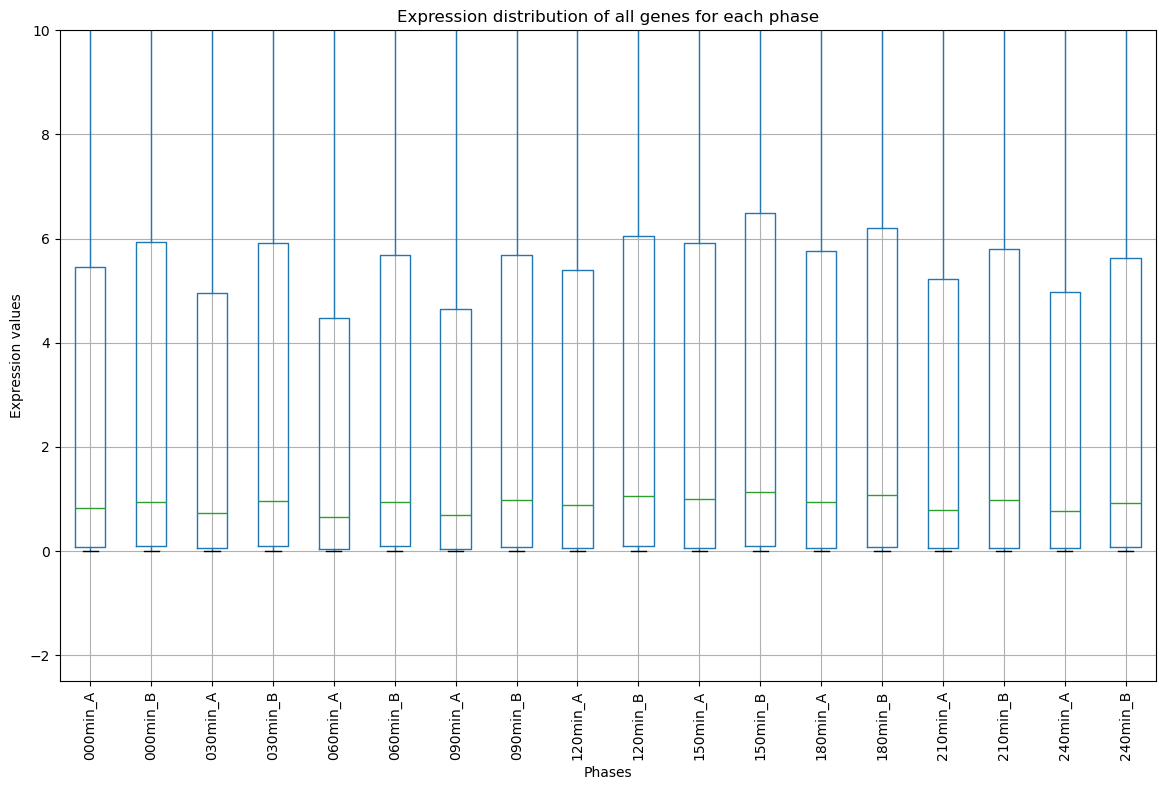

In [83]:
# Assuming you have your gene expression dataset loaded into a DataFrame called 'data'
# Columns: Genes (rows), Phases (columns)
# Rows: Genes, Expression values across phases

# Plot boxplot for each phase
plt.figure(figsize=(12, 8))
df_tpm_data.boxplot(rot=90)
plt.title('Expression distribution of all genes for each phase')
plt.xlabel('Phases')
plt.ylabel('Expression values')
plt.tight_layout()
plt.ylim(top=10)
plt.ylim(bottom=-2.5)
plt.show()


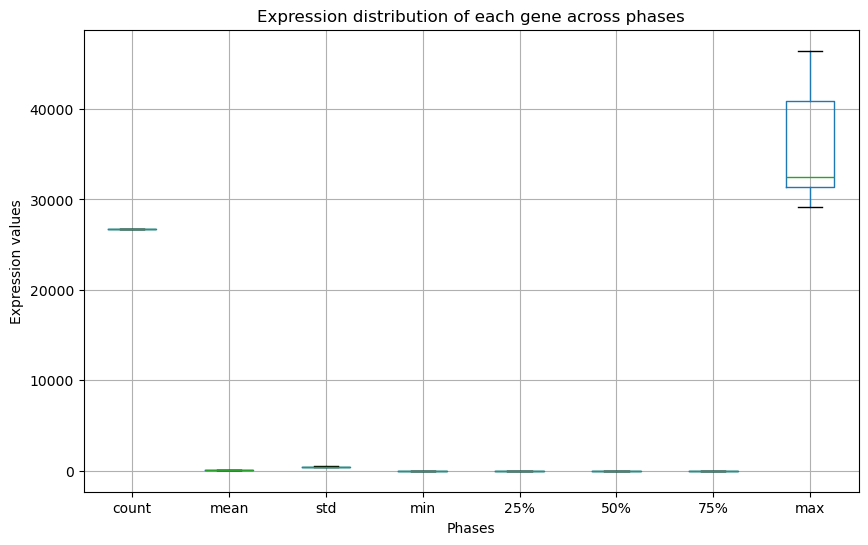

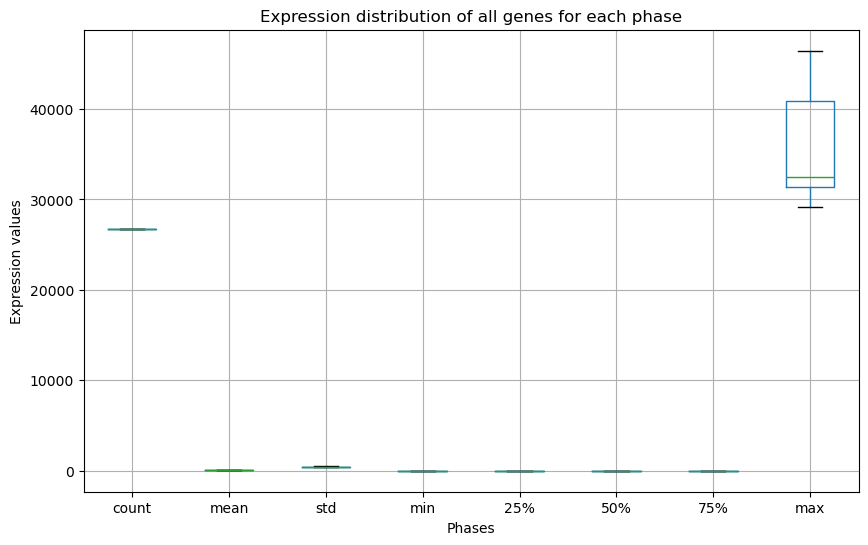

In [84]:
# Assuming you have your gene expression dataset loaded into a DataFrame called 'data'
# Columns: Genes (rows), Phases (columns)
# Rows: Genes, Expression values across phases

# Step 1: Phase-specific outliers
# Calculate expression distribution for each gene across phases
gene_expression_distribution = df_tpm_data.describe().T  # Transpose for easier processing

# Plot boxplots or histograms for each gene
plt.figure(figsize=(10, 6))
gene_expression_distribution.boxplot()
plt.title('Expression distribution of each gene across phases')
plt.xlabel('Phases')
plt.ylabel('Expression values')
plt.show()

# Step 2: Gene-specific outliers
# Calculate expression distribution for each phase across genes
phase_expression_distribution = df_tpm_data.describe()

# Plot boxplots or histograms for each phase
plt.figure(figsize=(10, 6))
phase_expression_distribution.T.boxplot()
plt.title('Expression distribution of all genes for each phase')
plt.xlabel('Phases')
plt.ylabel('Expression values')
plt.show()

In [85]:
# # Identify genes with consistently low or high expression values across phases
# gene_outliers = []
# for gene in data.index:
#     if (data.loc[gene] < threshold).all() or (data.loc[gene] > threshold).all():
#         gene_outliers.append(gene)

# # Filter out genes with consistent outlier behavior
# filtered_data = data.drop(gene_outliers, axis=0)

# Filter out genes

In [86]:
tpm_cols

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [87]:
df_no_all_zeros['max_tpm'] = df_no_all_zeros[tpm_cols].apply(lambda x: max(x), axis=1)
df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,180min_diff,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,...,0.955644,0.734952,0.871646,146.923636,35.081042,84.954104,143.780896,91.485513,53.459035,2.957370
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,...,0.454944,0.577222,0.315350,32.635300,101.593537,75.190670,81.685999,101.643963,25.185847,0.251897
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,...,0.400312,0.198406,0.427050,165.785533,135.748195,68.676735,13.938626,200.000000,200.000000,0.308601
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046924
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,...,0.808443,0.948041,0.821123,20.478417,27.217099,6.833906,20.006899,29.739814,9.879879,2.549160


In [88]:
TPM_THRESHOLD_PERCENTILE = 0

In [89]:
np.percentile(tpms_flattened[tpms_flattened != 0], TPM_THRESHOLD_PERCENTILE)

5.61531e-11

In [90]:
st.percentileofscore(tpms_flattened[tpms_flattened != 0], np.percentile(tpms_flattened[tpms_flattened != 0], TPM_THRESHOLD_PERCENTILE), kind='weak')

0.00023782287427969397

In [91]:
df_tpm_filtered = df_no_all_zeros.loc[df_no_all_zeros['max_tpm'] > np.percentile(tpms_flattened[tpms_flattened != 0], TPM_THRESHOLD_PERCENTILE)]
df_no_all_zeros.shape, df_tpm_filtered.shape

((25526, 35), (25526, 35))

In [92]:
df_tpm_filtered.loc[df_tpm_filtered['TTHERM_ID'].isin(target_ttherms)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,180min_diff,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm


In [93]:
diff_cols

['000min_diff',
 '030min_diff',
 '060min_diff',
 '090min_diff',
 '120min_diff',
 '150min_diff',
 '180min_diff',
 '210min_diff',
 '240min_diff']

In [94]:
df_no_all_zeros['min_diff'] = df_no_all_zeros[diff_cols].apply(lambda x: np.min(x[x != 0]) if len(x[x != 0]) > 0 else 0, axis=1)
df_no_all_zeros.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm,min_diff
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,...,0.734952,0.871646,146.923636,35.081042,84.954104,143.780896,91.485513,53.459035,2.957370,0.296726
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,...,0.577222,0.315350,32.635300,101.593537,75.190670,81.685999,101.643963,25.185847,0.251897,0.066397
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,...,0.198406,0.427050,165.785533,135.748195,68.676735,13.938626,200.000000,200.000000,0.308601,0.096977
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046924,1.000000
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,...,0.948041,0.821123,20.478417,27.217099,6.833906,20.006899,29.739814,9.879879,2.549160,0.808443


In [95]:
df_no_all_zeros_zero_min_diffs = df_no_all_zeros.loc[df_no_all_zeros['min_diff'] == 0].loc[:, ['TTHERM_ID']+diff_cols]
df_no_all_zeros_zero_min_diffs.shape

(9, 10)

In [96]:
df_no_all_zeros.loc[df_no_all_zeros['TTHERM_ID']=='YF00000043.t1'].loc[:, ['TTHERM_ID'] + diff_cols]

,TTHERM_ID,000min_diff,030min_diff,060min_diff,090min_diff,120min_diff,150min_diff,180min_diff,210min_diff,240min_diff


In [97]:
DIFF_THRESHOLD_PERCENTILE = 0

In [98]:
np.percentile(diffs_flattened[diffs_flattened != 0], DIFF_THRESHOLD_PERCENTILE)

1.1169780012570711e-09

In [99]:
st.percentileofscore(diffs_flattened[diffs_flattened != 0], np.percentile(diffs_flattened[diffs_flattened != 0], DIFF_THRESHOLD_PERCENTILE), kind='weak')

0.0004621306998045187

In [100]:
df_diff_filtered = df_no_all_zeros.loc[df_no_all_zeros['min_diff'] > np.percentile(diffs_flattened[diffs_flattened != 0], DIFF_THRESHOLD_PERCENTILE)]
df_no_all_zeros.shape, df_diff_filtered.shape

((25526, 36), (25516, 36))

In [101]:
list(np.unique(max_tpm_ttherms))

['TTHERM_00526400', 'TTHERM_00760295', 'TTHERM_01068180']

In [102]:
df_diff_filtered.loc[df_diff_filtered['TTHERM_ID'].isin(list(np.unique(max_tpm_ttherms)))]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm,min_diff
13693,TTHERM_00526400,19469.2,41122.1,20515.1,36852.5,19981.7,39829.2,23785.1,40222.7,24843.30,...,0.790908,0.821846,3.970089,53.918101,50.216746,3.109539,35.467197,38.470666,46447.0,0.473449
19332,TTHERM_00760295,20068.8,32577.0,30392.4,46285.4,21585.6,44911.6,10905.5,36453.3,6842.48,...,0.708918,0.921805,59.420051,71.941266,14.019458,43.925127,74.766219,33.599727,46285.4,0.228820
23691,TTHERM_01068180,29123.3,22688.4,31265.3,23687.7,32316.9,24131.6,31502.3,23570.4,30837.10,...,0.985133,0.962116,5.740738,31.933109,23.363420,5.392200,29.079200,23.780220,34335.0,0.716144


In [103]:
df_filtered = df_diff_filtered.merge(df_tpm_filtered, how='inner', on='TTHERM_ID')
print('# genes in df_tpm_filtered:', df_tpm_filtered.shape[0])
print('# genes in df_diff_filtered:', df_diff_filtered.shape[0])
print('# genes in df_filtered:', df_filtered.shape[0])

# genes in df_tpm_filtered: 25526
# genes in df_diff_filtered: 25516
# genes in df_filtered: 25516


In [104]:
df_no_all_zeros.loc[df_no_all_zeros['TTHERM_ID'].isin(list(np.unique(max_tpm_ttherms)))]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,...,210min_diff,240min_diff,percent_diff_000min_A_210min_A,percent_diff_000min_B_210min_B,percent_diff_000min_diff_210min_diff,percent_diff_030min_A_240min_A,percent_diff_030min_B_240min_B,percent_diff_030min_diff_240min_diff,max_tpm,min_diff
13693,TTHERM_00526400,19469.2,41122.1,20515.1,36852.5,19981.7,39829.2,23785.1,40222.7,24843.30,...,0.790908,0.821846,3.970089,53.918101,50.216746,3.109539,35.467197,38.470666,46447.0,0.473449
19332,TTHERM_00760295,20068.8,32577.0,30392.4,46285.4,21585.6,44911.6,10905.5,36453.3,6842.48,...,0.708918,0.921805,59.420051,71.941266,14.019458,43.925127,74.766219,33.599727,46285.4,0.228820
23691,TTHERM_01068180,29123.3,22688.4,31265.3,23687.7,32316.9,24131.6,31502.3,23570.4,30837.10,...,0.985133,0.962116,5.740738,31.933109,23.363420,5.392200,29.079200,23.780220,34335.0,0.716144


In [105]:
df_filtered_diffs_flattened = df_diff_filtered.loc[:, diff_cols].to_numpy().flatten()

In [106]:
# plt.hist(df_filtered_diffs_flattened, bins=10000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='line at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('∆TPM Between Duplicates')
# plt.ylabel('# of ∆TPMs')
# plt.title(f'Distribution of ∆TPM Between Duplicates')

# plt.show()

# plt.hist(df_filtered_diffs_flattened, bins=10000, edgecolor='black')

# # line_num = 200
# # plt.axvline(x=line_num, color='red', linestyle='dashed', linewidth=0.5, label='line at x={}'.format(line_num))
# # plt.legend()

# plt.xlabel('∆TPM Between Duplicates')
# plt.ylabel('# of ∆TPMs')
# plt.title(f'Distribution of ∆TPM Between Duplicates')

# plt.ylim(top=200)

# plt.show()

# Export the filtered TPM data to CSV

# FILTER BY RAW COUNT SELECTION

In [107]:
df_no_all_zeros.shape, df_all_tpm.shape

((25526, 36), (26686, 19))

In [108]:
# df_filtered = df_no_all_zeros # FIXME
# df_filtered = df_no_all_zeros.loc[df_no_all_zeros['TTHERM_ID'].isin(complete_data_df_filtered['TTHERM_ID'].values)]

df_filtered = df_all_tpm.loc[df_all_tpm['TTHERM_ID'].isin(df_all_cpm_filtered['TTHERM_ID'].values)]

In [109]:
df_filtered.shape

(23112, 19)

In [110]:
df_filtered.loc[df_filtered['TTHERM_ID'].isin(df_all_zeros['TTHERM_ID'].values)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [111]:
df_filtered.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,0.330559,0.317093,0.350251,0.456802,0.436540,0.368480,0.501366,0.483624,0.554840
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,0.045545,0.112639,0.030162,0.031347,0.068903,0.091381,0.052747,0.251897,0.079436
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,0.014850,0.019588,0.010490,0.010895,0.027217,0.028866,0.005727,0.024873,0.010622
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,2.232350,2.203750,2.413930,1.952220,2.414790,1.837740,1.938460,1.785950,2.175010
5,TTHERM_00000047,0.125703,0.062189,0.134722,0.144436,0.163839,0.187904,0.415551,0.492354,0.993735,0.693446,1.848730,0.707902,1.915730,1.076950,0.623573,1.039970,0.211403,0.626801


In [112]:
df_filtered[tpm_cols].max(axis=None)

46447.0

In [113]:
df_filtered.loc[:, all_cols].to_csv('./tpm_kallisto.csv', index=False)

# Normalize expression per gene with zscore

In [114]:
# normalized_tpm_df = normalize_expression_per_gene(df_filtered)
normalized_tpm_df = df_filtered

Sanity check

In [115]:
row_to_check = normalized_tpm_df.loc[2, normalized_tpm_df.columns[1:]] 

row_mean = np.mean(row_to_check)
row_std = np.std(row_to_check)

print(row_mean)
print(row_std)

0.032586151111111114
0.06759124903624868


In [116]:
normalized_tpm_df.shape

(23112, 19)

In [117]:
normalized_tpm_df

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,0.330559,0.317093,0.350251,0.456802,0.436540,0.368480,0.501366,0.483624,0.554840
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,0.045545,0.112639,0.030162,0.031347,0.068903,0.091381,0.052747,0.251897,0.079436
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,0.014850,0.019588,0.010490,0.010895,0.027217,0.028866,0.005727,0.024873,0.010622
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,2.232350,2.203750,2.413930,1.952220,2.414790,1.837740,1.938460,1.785950,2.175010
5,TTHERM_00000047,0.125703,0.062189,0.134722,0.144436,0.163839,0.187904,0.415551,0.492354,0.993735,0.693446,1.848730,0.707902,1.915730,1.076950,0.623573,1.039970,0.211403,0.626801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26679,TTHERM_02653503,0.987275,3.746770,1.423860,5.402760,1.895580,5.798440,2.144770,6.895340,2.525350,6.124430,1.542040,5.351530,0.959011,3.227840,0.498040,3.724690,2.295390,3.146150
26680,TTHERM_02653508,8.736360,15.887400,9.227230,14.731600,12.128600,16.979900,14.272500,17.341700,12.093600,18.363500,10.444800,17.967400,7.865660,13.160200,8.075010,10.029100,9.222800,10.063600
26682,TTHERM_02653516,1.055300,0.991837,0.598979,0.864190,0.302904,0.606287,0.238977,0.542659,0.221258,0.771146,0.312396,0.565463,0.236132,0.563077,0.435520,0.511777,0.574854,0.650485
26683,TTHERM_02653518,1.441810,1.248970,1.232530,1.410600,0.792453,0.994460,0.625057,0.940775,0.733694,0.765066,0.715717,0.773770,0.768118,0.826215,0.950177,1.082260,1.220590,1.172860


# MEAN TYPE SELECTION

In [118]:
# df_filtered_averaged = ari_mean_df_of_duplicates(normalized_tpm_df.loc[:, all_cols])
# df_filtered_averaged = geo_mean_df_of_duplicates(df_filtered.loc[:, all_cols])
# df_filtered_averaged
df_filtered_averaged = df_filtered

In [119]:
df_filtered.loc[:, all_cols]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,0.330559,0.317093,0.350251,0.456802,0.436540,0.368480,0.501366,0.483624,0.554840
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,0.045545,0.112639,0.030162,0.031347,0.068903,0.091381,0.052747,0.251897,0.079436
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,0.014850,0.019588,0.010490,0.010895,0.027217,0.028866,0.005727,0.024873,0.010622
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,2.232350,2.203750,2.413930,1.952220,2.414790,1.837740,1.938460,1.785950,2.175010
5,TTHERM_00000047,0.125703,0.062189,0.134722,0.144436,0.163839,0.187904,0.415551,0.492354,0.993735,0.693446,1.848730,0.707902,1.915730,1.076950,0.623573,1.039970,0.211403,0.626801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26679,TTHERM_02653503,0.987275,3.746770,1.423860,5.402760,1.895580,5.798440,2.144770,6.895340,2.525350,6.124430,1.542040,5.351530,0.959011,3.227840,0.498040,3.724690,2.295390,3.146150
26680,TTHERM_02653508,8.736360,15.887400,9.227230,14.731600,12.128600,16.979900,14.272500,17.341700,12.093600,18.363500,10.444800,17.967400,7.865660,13.160200,8.075010,10.029100,9.222800,10.063600
26682,TTHERM_02653516,1.055300,0.991837,0.598979,0.864190,0.302904,0.606287,0.238977,0.542659,0.221258,0.771146,0.312396,0.565463,0.236132,0.563077,0.435520,0.511777,0.574854,0.650485
26683,TTHERM_02653518,1.441810,1.248970,1.232530,1.410600,0.792453,0.994460,0.625057,0.940775,0.733694,0.765066,0.715717,0.773770,0.768118,0.826215,0.950177,1.082260,1.220590,1.172860


# Filter out genes with all zeros

In [120]:
df_filtered_averaged_with_all_zeros = df_filtered_averaged[(df_filtered_averaged.iloc[:, 1:] == 0.0).all(axis=1)]

print(df_filtered_averaged_with_all_zeros.shape)

df_filtered_averaged_with_all_zeros.head()

(0, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [121]:
df_filtered_averaged_no_all_zeros = df_filtered_averaged[~df_filtered_averaged.isin(df_filtered_averaged_with_all_zeros)].dropna()
df_filtered_averaged_no_all_zeros.reset_index()
print(df_filtered_averaged.shape[0])
print(df_filtered_averaged_no_all_zeros.shape[0])
print(df_filtered_averaged.shape[0]-df_filtered_averaged_no_all_zeros.shape[0])
df_filtered_averaged_no_all_zeros.head()

23112
23112
0


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,0.330559,0.317093,0.350251,0.456802,0.436540,0.368480,0.501366,0.483624,0.554840
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,0.045545,0.112639,0.030162,0.031347,0.068903,0.091381,0.052747,0.251897,0.079436
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,0.014850,0.019588,0.010490,0.010895,0.027217,0.028866,0.005727,0.024873,0.010622
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,2.232350,2.203750,2.413930,1.952220,2.414790,1.837740,1.938460,1.785950,2.175010
5,TTHERM_00000047,0.125703,0.062189,0.134722,0.144436,0.163839,0.187904,0.415551,0.492354,0.993735,0.693446,1.848730,0.707902,1.915730,1.076950,0.623573,1.039970,0.211403,0.626801


In [122]:
df_filtered_averaged_no_all_zeros[df_filtered_averaged_no_all_zeros['TTHERM_ID'].isin(satellite_ttherm_ids)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


# SATELLITE GENE TPMS

In [123]:
(df_no_all_zeros[df_no_all_zeros['TTHERM_ID'].isin(satellite_ttherm_ids)])[all_cols]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [124]:
df_filtered_averaged_no_all_zeros

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.408500,0.714664,2.957370,1.490380,0.556999,0.534218,0.189114,0.398338,0.231842,0.330559,0.317093,0.350251,0.456802,0.436540,0.368480,0.501366,0.483624,0.554840
1,TTHERM_00000020,0.065742,0.017211,0.105802,0.025901,0.065942,0.068509,0.093143,0.006184,0.127514,0.045545,0.112639,0.030162,0.031347,0.068903,0.091381,0.052747,0.251897,0.079436
2,TTHERM_00000030,0.308601,0.029927,0.021632,0.000000,0.000000,0.009159,0.024913,0.026873,0.012318,0.014850,0.019588,0.010490,0.010895,0.027217,0.028866,0.005727,0.024873,0.010622
4,TTHERM_00000040,2.257010,2.549160,1.461130,1.611900,1.714520,1.882660,1.821900,2.025710,2.036640,2.232350,2.203750,2.413930,1.952220,2.414790,1.837740,1.938460,1.785950,2.175010
5,TTHERM_00000047,0.125703,0.062189,0.134722,0.144436,0.163839,0.187904,0.415551,0.492354,0.993735,0.693446,1.848730,0.707902,1.915730,1.076950,0.623573,1.039970,0.211403,0.626801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26679,TTHERM_02653503,0.987275,3.746770,1.423860,5.402760,1.895580,5.798440,2.144770,6.895340,2.525350,6.124430,1.542040,5.351530,0.959011,3.227840,0.498040,3.724690,2.295390,3.146150
26680,TTHERM_02653508,8.736360,15.887400,9.227230,14.731600,12.128600,16.979900,14.272500,17.341700,12.093600,18.363500,10.444800,17.967400,7.865660,13.160200,8.075010,10.029100,9.222800,10.063600
26682,TTHERM_02653516,1.055300,0.991837,0.598979,0.864190,0.302904,0.606287,0.238977,0.542659,0.221258,0.771146,0.312396,0.565463,0.236132,0.563077,0.435520,0.511777,0.574854,0.650485
26683,TTHERM_02653518,1.441810,1.248970,1.232530,1.410600,0.792453,0.994460,0.625057,0.940775,0.733694,0.765066,0.715717,0.773770,0.768118,0.826215,0.950177,1.082260,1.220590,1.172860


In [125]:
df_filtered_averaged_no_all_zeros[df_filtered_averaged_no_all_zeros.isna().any(axis=1)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [126]:
df_filtered_averaged_no_all_zeros.sample(10)

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
13395,TTHERM_00503770,8.877700,0.134069,2.475920,0.380534,2.022930,0.719425,1.260730,0.329374,1.406350,1.160840,1.091440,0.807805,0.484810,0.482682,0.742716,0.078990,1.295650,0.721529
5179,TTHERM_00195890,21.898000,27.586200,28.944800,32.339700,28.441600,33.838000,29.750900,33.075100,26.042300,28.986800,30.214500,26.265500,40.938800,29.677200,45.424200,36.146000,39.762300,36.255700
7701,TTHERM_00300030,8.494920,5.760060,6.728390,5.012340,6.340750,4.469180,6.054060,4.659690,5.744190,4.479980,6.168780,4.402090,6.337540,5.654300,6.117170,5.799380,5.590710,5.705400
4422,TTHERM_00161660,68.484900,78.369200,46.022400,61.363400,25.331200,41.351000,25.166700,43.139200,42.032500,52.704100,61.792400,64.526400,90.761000,72.012100,83.026600,81.737800,66.029500,83.069000
24228,TTHERM_01106220,0.604513,0.738011,1.299220,1.290240,2.073030,1.803700,2.130240,2.229660,2.582290,2.005050,1.965880,1.727100,1.077980,1.538010,0.995864,1.449460,1.722380,1.152410
18704,TTHERM_00723410,18.244400,10.931500,9.938190,8.964870,7.216030,6.633450,6.319820,6.073050,6.498800,5.998350,7.357260,5.671830,8.850400,7.219870,11.192400,8.855950,9.576560,8.834940
458,TTHERM_00022790,17.512200,61.114400,24.716600,46.517300,14.739200,44.751800,14.821100,55.362500,20.666000,48.168400,20.565400,50.584800,16.284700,41.876400,15.100600,28.070800,24.161800,27.285600
14751,TTHERM_00564130,3.834280,12.934300,7.269370,14.384000,9.147070,19.183400,10.130600,18.093400,8.789850,16.461300,7.677120,17.944100,5.567870,9.933820,6.185940,6.117160,7.407200,7.559520
3980,TTHERM_00149490,0.262291,0.113446,0.240769,0.209109,0.260388,0.283856,0.236848,0.319195,0.525271,0.359447,0.702765,0.383220,0.608614,0.513303,0.239109,0.429358,0.269241,0.364308
200,TTHERM_00011197,0.438719,0.297188,0.231748,0.320195,0.244907,0.379261,0.194806,0.459907,0.436981,0.898464,0.259081,0.802953,0.295831,0.435080,0.351786,0.443782,0.241593,0.378091


In [127]:
df_filtered_averaged_no_all_zeros.to_csv('./kallisto.csv', index=False)